# Process Normalized Cross-Study Dataset

For differential expression analysis, we processed all of the data together on a high memory node.  This was done using the minfi package in R, and all data were normalized using the preprocessQuantile function.  For a full script of the R pipeline see the [Methylation_Normalization_MINFI](./Methylation_Normalization_MINFI.ipynb) notebook.

Imports and helper functions from [Imports](Imports.ipynb) notebook.

In [1]:
import os 
if os.getcwd().endswith('Validation'):
    os.chdir('..')

In [2]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


### Read in Validation Data

In [3]:
path = '/cellar/users/agross/TCGA_Code/Methlation/data/Validation/'

In [4]:
df_hiv =  pd.read_csv(path + 'BMIQ_Hannum2.csv', index_col=0)

In [5]:
cell_type = pd.Series(df_hiv.columns, index=df_hiv.columns)
cell_type = cell_type.map(lambda s: s.strip()[-3:])

In [6]:
df_hiv.shape

(485512, 94)

In [11]:
cell_type.value_counts()

Neu    48
CD4    46
dtype: int64

#### Read in annotations 

In [133]:
hiv_ann = pd.read_excel(path + 'Methylome human NEUvs WB.xlsx', 
                        sheetname='HIV', skiprows=2, index_col=0)
control_ann = pd.read_excel(path + 'Methylome human NEUvs WB.xlsx',
                            sheetname='Negative', skiprows=2, index_col=0)
ann = pd.concat([hiv_ann, control_ann], keys=['HIV+','HIV-'])
ann = ann.reset_index()
ann = ann.rename(columns={'Age (years)': 'age', 'level_0':'HIV'})
ann = ann.set_index('PATID')

In [134]:
hiv_ann = pd.read_excel(path + 'Methylome human NEUvs WB.xlsx', 
                        sheetname='HIV', skiprows=2, index_col=0)
control_ann = pd.read_excel(path + 'Methylome human NEUvs WB.xlsx',
                            sheetname='Negative', skiprows=2, index_col=0)
ann = pd.concat([hiv_ann, control_ann], keys=['HIV+','HIV-'])
ann = ann.reset_index()
ann = ann.rename(columns={'Age (years)': 'age', 'level_0':'HIV'})
ann = ann.set_index('PATID')

m2 = pd.read_excel('/cellar/users/agross/Downloads_Old/Methylome Study Demographic Data.xlsx',
              skiprows=5, index_col=0)
age2 = m2['Age (years)']
ann = ann.ix[ann.index.union(age2.index)]
ann['age'] = age2.combine_first(ann.age)
ann['HIV'] = ann.HIV.fillna('HIV+')

In [135]:
age_n = pd.Series({'{}_Neu'.format(i[3:]): v for i,v in ann.age.iteritems()})
age_t = pd.Series({'{}_CD4'.format(i[3:]): v for i,v in ann.age.iteritems()})
age = pd.concat([age_n, age_t])

hiv_n = pd.Series({'{}_Neu'.format(i[3:]): v for i,v in ann.HIV.iteritems()})
hiv_t = pd.Series({'{}_CD4'.format(i[3:]): v for i,v in ann.HIV.iteritems()})
hiv = pd.concat([hiv_n, hiv_t])
hiv = hiv == 'HIV+'

In [9]:
import Setup.DX_Imports as dx
import Parallel.Age_HIV_Features as fx

importing IPython notebook from Setup/DX_Imports

importing IPython notebook from Parallel/Age_HIV_Features

importing IPython notebook from HIV_Age_Advancement

importing IPython notebook from Setup/MethylationAgeModels

importing IPython notebook from Setup/Read_HIV_Data

In [172]:
neu_corr = pd.read_csv('/cellar/users/agross/Data/Methylation_Controls/neutrophils_age_corr.csv',
                            index_col=0, squeeze=True)
cd4_corr = pd.read_csv('/cellar/users/agross/Data/Methylation_Controls/CD4T_age_corr.csv',
                            index_col=0, squeeze=True)

In [466]:
r2 = ti(fx.rr > 1)
r4 = r2.intersection(ti(cd4_corr.abs() > .2))
#r4 = cd4_corr.abs().ix[r2].dropna().order()[-10000:].index
len(r4)

5999

In [467]:
df = df_hiv.ix[r4, ti(cell_type=='CD4')].dropna(1)
dd = logit_adj(df)
m = dd.mean(1)
s = dd.std(1)
df_norm = dd.subtract(m, axis=0).divide(s, axis=0)

In [468]:
U,S,vH = frame_svd(df_norm)

In [469]:
p = S ** 2 / sum(S ** 2)
p[:5]

array([ 0.25161156,  0.18350819,  0.06644469,  0.0508525 ,  0.03071282])

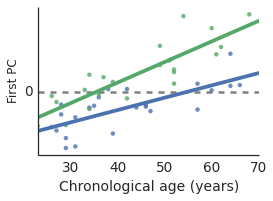

In [470]:
fig, ax = subplots(1,1, figsize=(4,3))
rr1 = -1*vH[0]

sns.regplot(*match_series(age, rr1.ix[ti(hiv==0)]),
            ax=ax, label='HIV+', ci=None)
sns.regplot(*match_series(age, rr1.ix[ti(hiv>0)]),
            ax=ax, label='Control', ci=None)
ax.set_ylabel('First PC', size=12)
ax.set_xlabel('Chronological age (years)', size=14)

ax.set_yticks([0])
ax.axhline(0, ls='--', lw=2.5, color='grey', zorder=-1)
ax.set_xbound(23,70)
prettify_ax(ax)
fig.tight_layout()

In [492]:
r2 = ti(fx.rr > 1)
r4 = r2.intersection(ti(neu_corr.abs() > .2))
#r4 = neu_corr.abs().ix[r2].dropna().order()[-10000:].index
len(r4)

9971

In [503]:
df = df_hiv.ix[r4, ti(cell_type=='Neu')].dropna(1)
dd = logit_adj(df)
m = dd.mean(1)
s = dd.std(1)
df_norm = dd.subtract(m, axis=0).divide(s, axis=0)

In [504]:
U,S,vH = frame_svd(df_norm)
p = S ** 2 / sum(S ** 2)
p[:5]

array([ 0.13505059,  0.10045817,  0.07619568,  0.04236922,  0.03697217])

In [505]:
((vH[0] - vH[0].mean()) / vH[0].std()).abs().order().tail()

204_Neu    1.40
206_Neu    1.44
219_Neu    1.82
379_Neu    2.26
383_Neu    4.39
Name: 0, dtype: float64

In [506]:
U,S,vH = frame_svd(df_norm[[p for p in df_norm.columns if p != '383_Neu']])
p = S ** 2 / sum(S ** 2)
p[:5]

array([ 0.12436987,  0.08794486,  0.07264244,  0.0443376 ,  0.03394085])

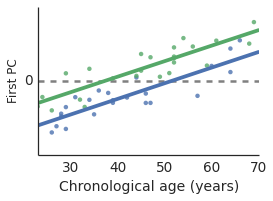

In [507]:
fig, ax = subplots(1,1, figsize=(4,3))
rr2 = -1*vH[0]

sns.regplot(*match_series(age, rr2.ix[ti(hiv==0)]),
            ax=ax, label='HIV+', ci=None)
sns.regplot(*match_series(age, rr2.ix[ti(hiv>0)]),
            ax=ax, label='Control', ci=None)
ax.set_ylabel('First PC', size=12)
ax.set_xlabel('Chronological age (years)', size=14)

ax.set_yticks([0])
ax.axhline(0, ls='--', lw=2.5, color='grey', zorder=-1)
ax.set_xbound(23,70)
#ax.set_ybound(-.25,.25)
prettify_ax(ax)
fig.tight_layout()

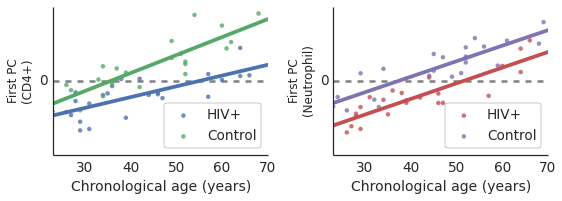

In [509]:
fig, axs = subplots(1,2, figsize=(8,3))

ax = axs[0]
sns.regplot(*match_series(age, rr1.ix[ti(hiv==0)]),
            ax=ax, label='HIV+', ci=None)
sns.regplot(*match_series(age, rr1.ix[ti(hiv>0)]),
            ax=ax, label='Control', ci=None)
ax.set_ylabel('First PC\n(CD4+)', size=12)

ax = axs[1]
sns.regplot(*match_series(age, rr2.ix[ti(hiv==0)]),
            ax=ax, label='HIV+', ci=None)
sns.regplot(*match_series(age, rr2.ix[ti(hiv>0)]),
            ax=ax, label='Control', ci=None)
ax.set_ylabel('First PC\n(Neutrophil)', size=12)

for ax in axs:
    ax.legend(loc='lower right', frameon=True, fancybox=True)
    ax.set_xlabel('Chronological age (years)', size=14)

    ax.set_yticks([0])
    ax.axhline(0, ls='--', lw=2.5, color='grey', zorder=-1)
    ax.set_xbound(23,70)
    prettify_ax(ax)
    
fig.tight_layout()
fig.savefig(FIGDIR + 'PCA_sorted.png', dpi=200)